# Project Overview: Dental X-Ray Feature Learning via SimCLR
This notebook implements a Self-Supervised Learning (SSL) pipeline using the SimCLR (Simple Framework for Contrastive Learning of Visual Representations) algorithm. The goal is to pre-train a YOLOv11 backbone on dental X-ray images to learn robust features without labels, followed by a supervised fine-tuning stage for tooth detection and classification.

## Dataset
* Data prep: Root (Source): /kaggle/input/dental-x-ray/...

* Target: Automatically converts and organizes source data into YOLO format under /kaggle/working/datasets/dental.
Performs an 80/20 train/validation split and scans label files to identify 6 unique dental classes.

## Results (SimCLR) 
* Detection Performance: The final mAP50 was 0.187, which is statistically identical to 
the MoCo result, suggesting both SSL methods learned similar quality features for this 
specific dataset. 
* Counting Error (MAE): 
* Tooth_Class_3: MAE 1.09 
* Tooth_Class_4: MAE 0.99 
* Tooth_Class_0 & 1: Higher error rates (~2.3 - 2.6), indicating these classes are 
harder for the model to detect or count accurately. 

## Initialization and Environment Setup

In [ ]:
!pip install -U ultralytics --no-deps -q
import os
import glob
import random
import shutil
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Set Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Environment ready. Using device: {DEVICE}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Environment ready. Using device: cuda


## --- CONFIGURATION ---

In [ ]:
CONFIG = {
    "img_size": 224,      # 224 for speed during SimCLR
    "det_img_size": 640,  # 640 for high-res detection
    "batch_size": 32,
    "epochs_simclr": 50,
    "epochs_finetune": 50,
    "lr": 1e-3,
    "backbone": "yolo11n.pt", #  download this manually
    
    # INPUT PATHS (Verify these match your Kaggle input)
    "images_path": "/kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)/images",
    "labels_path": "/kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)/labels",
    
    # OUTPUT WORK DIR
    "work_dir": "/kaggle/working/datasets/dental"
}

# --- DATA ORGANIZATION ---
if os.path.exists(CONFIG["work_dir"]): shutil.rmtree(CONFIG["work_dir"])

# 1. Get Files
all_images = glob.glob(os.path.join(CONFIG["images_path"], "*.jpg")) + \
             glob.glob(os.path.join(CONFIG["images_path"], "*.png"))
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# 2. Copy Files to Working Directory
print("Organizing dataset...")
for split, files in zip(['train', 'val'], [train_files, val_files]):
    os.makedirs(f"{CONFIG['work_dir']}/images/{split}", exist_ok=True)
    os.makedirs(f"{CONFIG['work_dir']}/labels/{split}", exist_ok=True)
    
    for img_path in files:
        # Copy Image
        file_name = os.path.basename(img_path)
        shutil.copy(img_path, f"{CONFIG['work_dir']}/images/{split}/{file_name}")
        
        # Copy Label
        lbl_name = file_name.rsplit('.', 1)[0] + ".txt"
        src_lbl = os.path.join(CONFIG["labels_path"], lbl_name)
        if os.path.exists(src_lbl):
            shutil.copy(src_lbl, f"{CONFIG['work_dir']}/labels/{split}/{lbl_name}")

print(f"Data setup complete. Train: {len(train_files)}, Val: {len(val_files)}")

Organizing dataset...
Data setup complete. Train: 1319, Val: 330


## ---Class Detection---

In [ ]:
print("Scanning labels to detect classes...")
label_files = glob.glob(f"{CONFIG['work_dir']}/labels/train/*.txt")
all_classes = []

for f in label_files:
    with open(f, 'r') as file:
        for line in file:
            c = int(line.split()[0])
            all_classes.append(c)

unique_classes = sorted(list(set(all_classes)))
NUM_CLASSES = len(unique_classes)

# Create a generic map if we don't know names
# Example: CLASS_NAMES = {0: 'Molar', 1: 'Canine'}
CLASS_NAMES = {i: f"Tooth_Class_{i}" for i in unique_classes}

print(f"--- DETECTED {NUM_CLASSES} CLASSES ---")
print(CLASS_NAMES)
CONFIG["num_classes"] = NUM_CLASSES

Scanning labels to detect classes...
--- DETECTED 6 CLASSES ---
{0: 'Tooth_Class_0', 1: 'Tooth_Class_1', 2: 'Tooth_Class_2', 3: 'Tooth_Class_3', 4: 'Tooth_Class_4', 5: 'Tooth_Class_5'}


## ---SimCLR Data Pipeline---

In [ ]:
class SimCLRTransform:
    def __init__(self, size):
        s = 1.0
        self.transform = T.Compose([
            T.Resize((size, size)),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.ToTensor(),
            # Normalization helps convergence
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

class DentalSimCLRDataset(Dataset):
    def __init__(self, image_paths, size=224):
        self.image_paths = image_paths
        self.transform = SimCLRTransform(size)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        x_i, x_j = self.transform(image)
        return x_i, x_j

# Create Loader
simclr_dataset = DentalSimCLRDataset(train_files, size=CONFIG["img_size"])
simclr_loader = DataLoader(
    simclr_dataset, 
    batch_size=CONFIG["batch_size"], 
    shuffle=True, 
    drop_last=True, 
    num_workers=2,
    pin_memory=True
)
print("DONE!")

DONE!


## ---Model Definition---

In [ ]:
# 1. Download Weights Manually to prevent FileNotFoundError
weight_url = "https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt"
weight_file = "yolo11n.pt"

if not os.path.exists(weight_file):
    print(f"Downloading {weight_file}...")
    response = requests.get(weight_url)
    with open(weight_file, "wb") as f: f.write(response.content)

class YOLO_SimCLR_V11(nn.Module):
    def __init__(self, backbone_path, projection_dim=128):
        super().__init__()
        
        # Load Model Wrapper
        print(f"Initializing Backbone from {backbone_path}...")
        yolo_temp = YOLO(backbone_path) 
        self.backbone = yolo_temp.model
        
        # --- THE FIX: Replace Head while keeping Attributes ---
        old_head = self.backbone.model[-1]
        self.backbone.model[-1] = nn.Identity()
        self.backbone.model[-1].i = old_head.i
        self.backbone.model[-1].f = old_head.f
        
        # Determine Feature Dimension dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            out = self.backbone(dummy)
            if isinstance(out, (list, tuple)): out = out[-1]
            self.feat_dim = out.shape[1]
            
        # Projection Head
        self.projector = nn.Sequential(
            nn.Linear(self.feat_dim, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        if isinstance(features, (list, tuple)): features = features[-1]
        h = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
        z = self.projector(h)
        return h, z

# Loss Function
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0)
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / self.temperature
        mask = torch.eye(2 * batch_size, device=z.device).bool()
        sim.masked_fill_(mask, -9e15)
        labels = torch.cat([torch.arange(batch_size, 2*batch_size), torch.arange(0, batch_size)]).to(z.device)
        return self.criterion(sim, labels)

model = YOLO_SimCLR_V11(weight_file).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
criterion = NTXentLoss(temperature=0.5)
print("Model Ready.")

Initializing Backbone from yolo11n.pt...
Model Ready.


## Defines DentalSimCLRDataset and SimCLRTransform

Starting SimCLR Training for 50 epochs...


Epoch 50: 100%|██████████| 41/41 [00:10<00:00,  4.02it/s, loss=3.2249]


SimCLR Weights Saved!


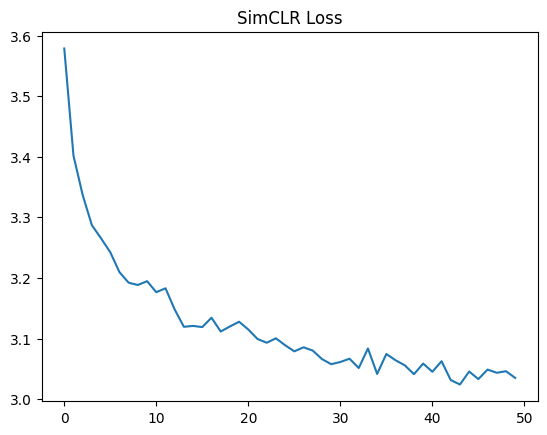

In [ ]:
loss_history = []
print(f"Starting SimCLR Training for {CONFIG['epochs_simclr']} epochs...")

model.train()
for epoch in range(CONFIG['epochs_simclr']):
    total_loss = 0
    pbar = tqdm(simclr_loader, desc=f"Epoch {epoch+1}", mininterval=1.0)
    
    for x_i, x_j in pbar:
        x_i, x_j = x_i.to(DEVICE), x_j.to(DEVICE)
        
        optimizer.zero_grad()
        _, z_i = model(x_i)
        _, z_j = model(x_j)
        
        loss = criterion(z_i, z_j)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
        
    avg_loss = total_loss / len(simclr_loader)
    loss_history.append(avg_loss)

# Save Weights
torch.save(model.backbone.state_dict(), "simclr_encoder_final.pt")
print("SimCLR Weights Saved!")

plt.plot(loss_history)
plt.title("SimCLR Loss")
plt.show()

## SimCLR Architecture

In [ ]:
# 1. Create Dynamic YAML
# We use the CLASS_NAMES we detected in Cell 3
yaml_content = f"""
path: {CONFIG['work_dir']}
train: images/train
val: images/val
names:
"""
for k, v in CLASS_NAMES.items():
    yaml_content += f"  {k}: {v}\n"

with open("dental_multiclass.yaml", "w") as f: f.write(yaml_content)

# 2. Initialize YOLOv11 for Detection
print("Initializing Detector...")
# IMPORTANT: define the model structure again for detection
detection_model = YOLO("yolo11n.pt") 

# 3. Load SimCLR Weights
try:
    print("Loading SimCLR Pre-trained Weights...")
    # Load state dict
    state_dict = torch.load("simclr_encoder_final.pt")
    
   
   
    detection_model.model.model.load_state_dict(state_dict, strict=False)
    print("Weights transferred successfully!")
except Exception as e:
    print(f"Warning: Weight transfer issue ({e}). Training from scratch.")

# 4. Train
results = detection_model.train(
    data="dental_multiclass.yaml",
    epochs=CONFIG["epochs_finetune"],
    imgsz=CONFIG["det_img_size"],
    batch=16, 
    project="Dental_Project",
    name="MultiClass_Run"
)

Initializing Detector...
Loading SimCLR Pre-trained Weights...
Weights transferred successfully!
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dental_multiclass.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=MultiClass_Run, nbs=64, nms=False, 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        330       3739      0.256      0.284      0.187     0.0521
         Tooth_Class_0        288        881      0.271      0.269      0.176     0.0482
         Tooth_Class_1        289        796      0.224      0.142      0.113     0.0303
         Tooth_Class_2        193        439      0.231     0.0934     0.0709     0.0206
         Tooth_Class_3        210        375      0.266       0.36      0.212     0.0625
         Tooth_Class_4        269        542      0.294       0.57       0.39      0.103
         Tooth_Class_5        278        706      0.251      0.269      0.159     0.0477
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /kaggle/working/Dental_Project/MultiClass_Run


## Pre-training

In [ ]:
def evaluate_multiclass(model_path, val_img_dir, val_lbl_dir, num_classes):
    model = YOLO(model_path)
    images = glob.glob(f"{val_img_dir}/*.jpg") + glob.glob(f"{val_img_dir}/*.png")
    
    # Store errors per class
    # Structure: {0: {'true': [], 'pred': []}, 1: ...}
    class_stats = {i: {'true': [], 'pred': []} for i in range(num_classes)}
    
    print("Running Multi-Class Inference...")
    for img in tqdm(images):
        # 1. Get True Counts
        file_name = os.path.basename(img).rsplit('.', 1)[0] + ".txt"
        lbl_path = os.path.join(val_lbl_dir, file_name)
        
        # Count true objects per class
        current_true = Counter()
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    cls = int(line.split()[0])
                    current_true[cls] += 1
        
        # 2. Get Pred Counts
        results = model.predict(img, conf=0.25, verbose=False)[0]
        # pred_classes is a tensor of class IDs found
        pred_classes = results.boxes.cls.cpu().numpy().astype(int)
        current_pred = Counter(pred_classes)
        
        # 3. Update Stats
        for c in range(num_classes):
            class_stats[c]['true'].append(current_true[c])
            class_stats[c]['pred'].append(current_pred[c])

    # Calculate MAE for each class
    print("\n" + "="*40)
    print(f"{'CLASS NAME':<20} | {'MAE':<10} | {'RMSE':<10}")
    print("="*40)
    
    for c in range(num_classes):
        t = np.array(class_stats[c]['true'])
        p = np.array(class_stats[c]['pred'])
        
        mae = np.mean(np.abs(t - p))
        rmse = np.sqrt(np.mean((t - p)**2))
        
        name = CLASS_NAMES.get(c, f"Class {c}")
        print(f"{name:<20} | {mae:.4f}     | {rmse:.4f}")

# Run Evaluation
best_weight = "/kaggle/working/Dental_Project/MultiClass_Run/weights/best.pt"
evaluate_multiclass(
    best_weight,
    f"{CONFIG['work_dir']}/images/val",
    f"{CONFIG['work_dir']}/labels/val",
    CONFIG["num_classes"]
)

Running Multi-Class Inference...


100%|██████████| 330/330 [00:05<00:00, 61.94it/s]


CLASS NAME           | MAE        | RMSE      
Tooth_Class_0        | 2.6545     | 3.3457
Tooth_Class_1        | 2.3182     | 2.8768
Tooth_Class_2        | 1.3182     | 2.1070
Tooth_Class_3        | 1.0939     | 1.5443
Tooth_Class_4        | 0.9909     | 1.3981
Tooth_Class_5        | 2.1030     | 2.6423


## Fine-Tuning

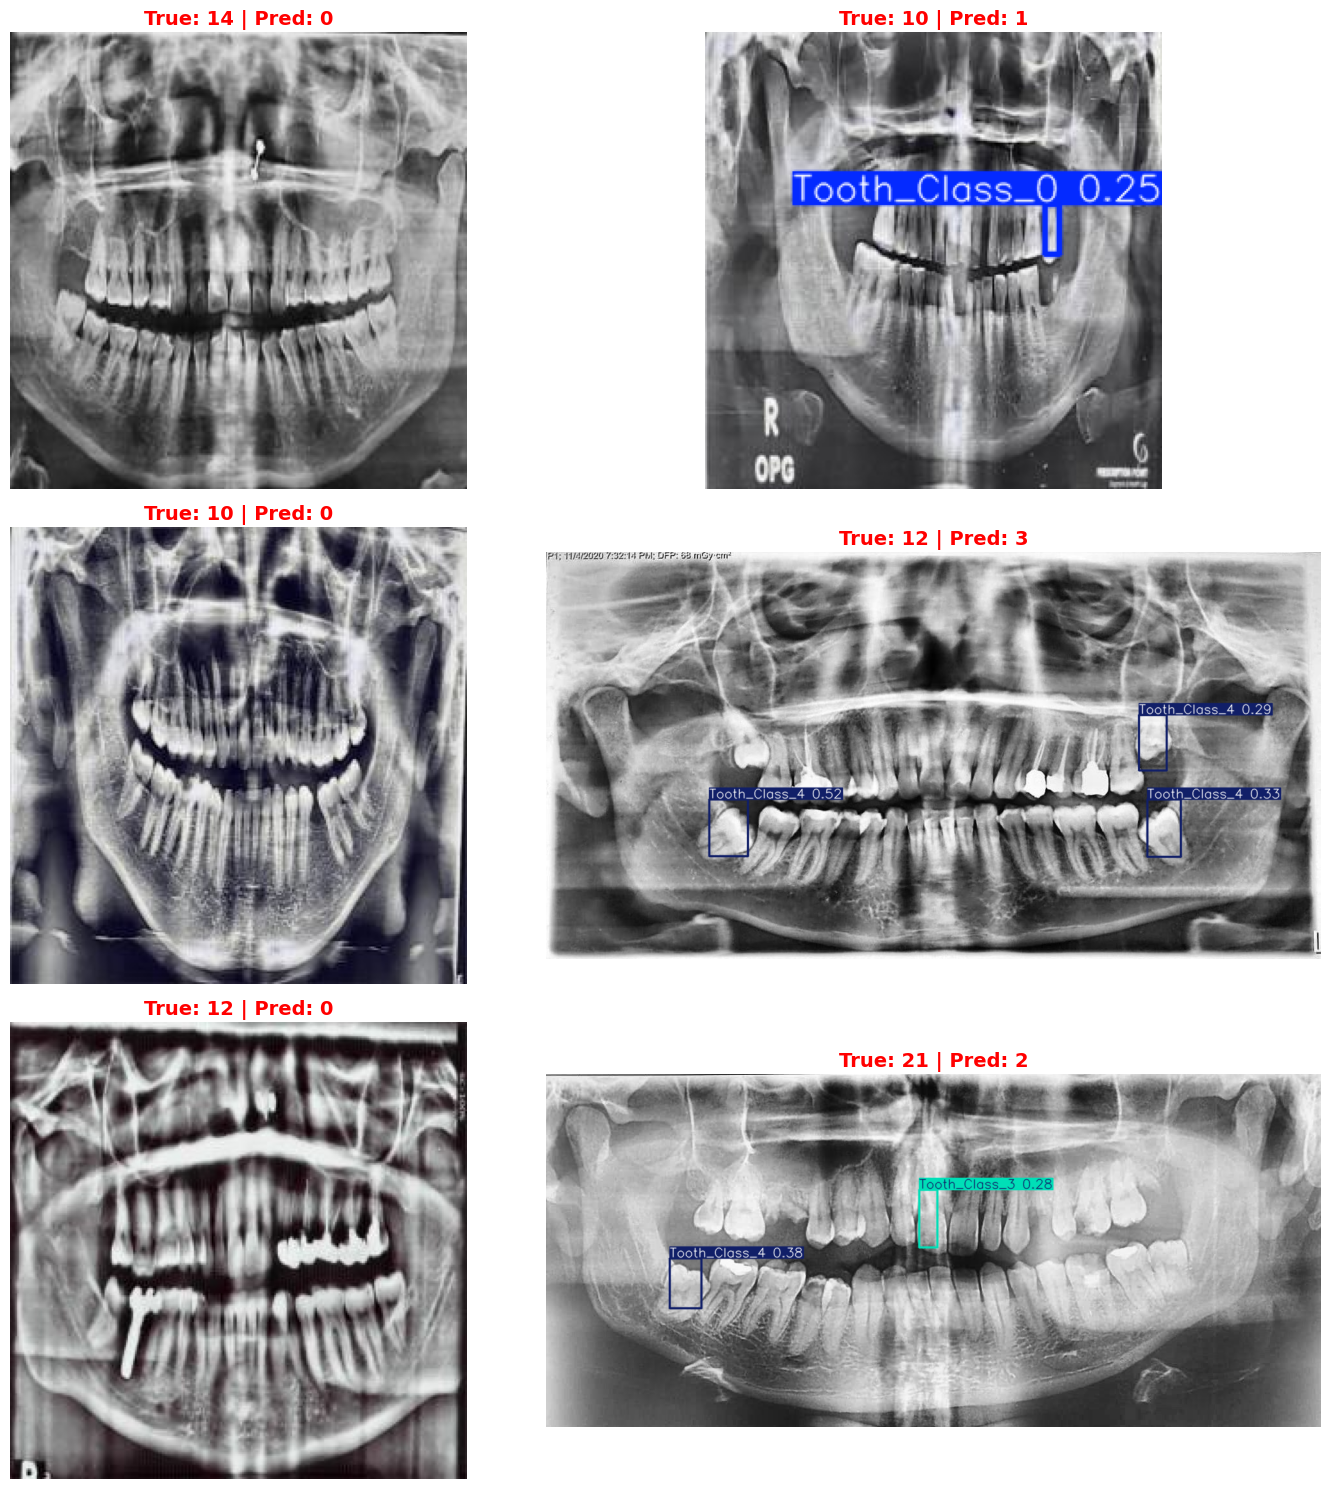

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt

def visualize_samples(model_path, img_dir, lbl_dir, num_samples=6):
    # Load Model
    model = YOLO(model_path)
    
    # Get list of images
    image_files = glob.glob(f"{img_dir}/*.jpg") + glob.glob(f"{img_dir}/*.png")
    
    if len(image_files) == 0:
        print("No images found to visualize.")
        return
        
    # Pick random samples
    samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Setup Plot Grid (2 columns)
    cols = 2
    rows = (len(samples) + 1) // cols
    plt.figure(figsize=(15, 5 * rows))
    
    for i, img_path in enumerate(samples):
        # 1. Get Ground Truth Count
        file_name = os.path.basename(img_path).rsplit('.', 1)[0] + ".txt"
        lbl_path = os.path.join(lbl_dir, file_name)
        
        true_count = 0
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                true_count = len(f.readlines())
        
        # 2. Run Inference
        results = model.predict(img_path, conf=0.25, verbose=False)[0]
        pred_count = len(results.boxes)
        
        # 3. Generate Image with Boxes
        # result.plot() returns a BGR numpy array, we need RGB for matplotlib
        res_plotted = results.plot(line_width=2, font_size=2)
        res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
        
        # 4. Display
        plt.subplot(rows, cols, i + 1)
        plt.imshow(res_rgb)
        
        # Color code the title: Green if correct, Red if wrong
        color = 'green' if true_count == pred_count else 'red'
        
        plt.title(f"True: {true_count} | Pred: {pred_count}", 
                  color=color, fontsize=14, fontweight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Run the visualizer
best_model_path = "/kaggle/working/Dental_Project/MultiClass_Run/weights/best.pt"
visualize_samples(
    best_model_path, 
    f"{CONFIG['work_dir']}/images/val", 
    f"{CONFIG['work_dir']}/labels/val",
    num_samples=6 # Change this to see more or fewer images
)

## Evaluation

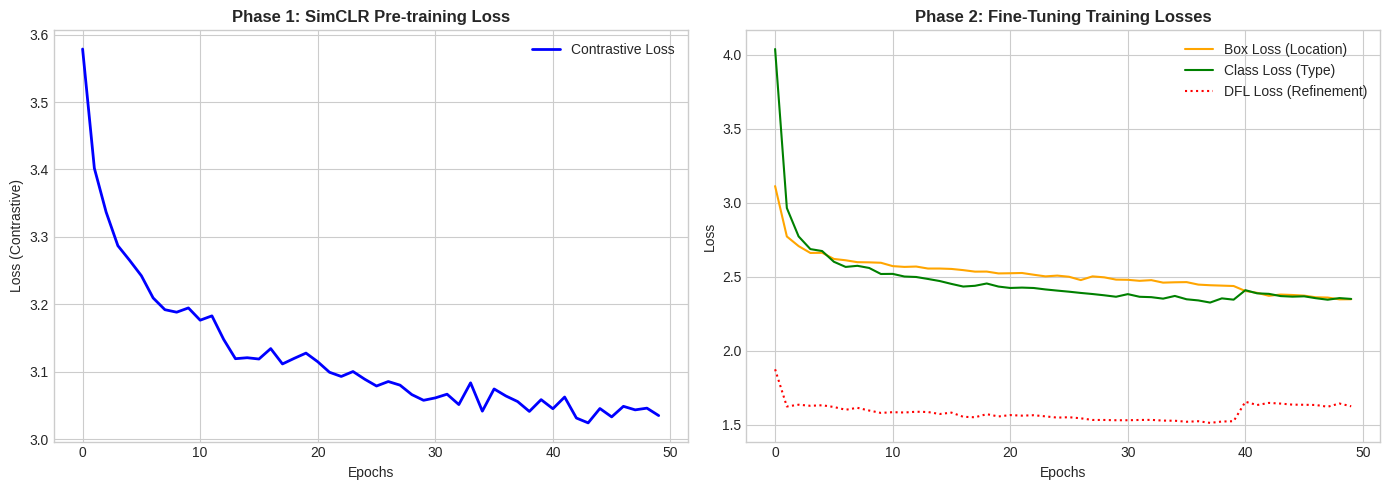

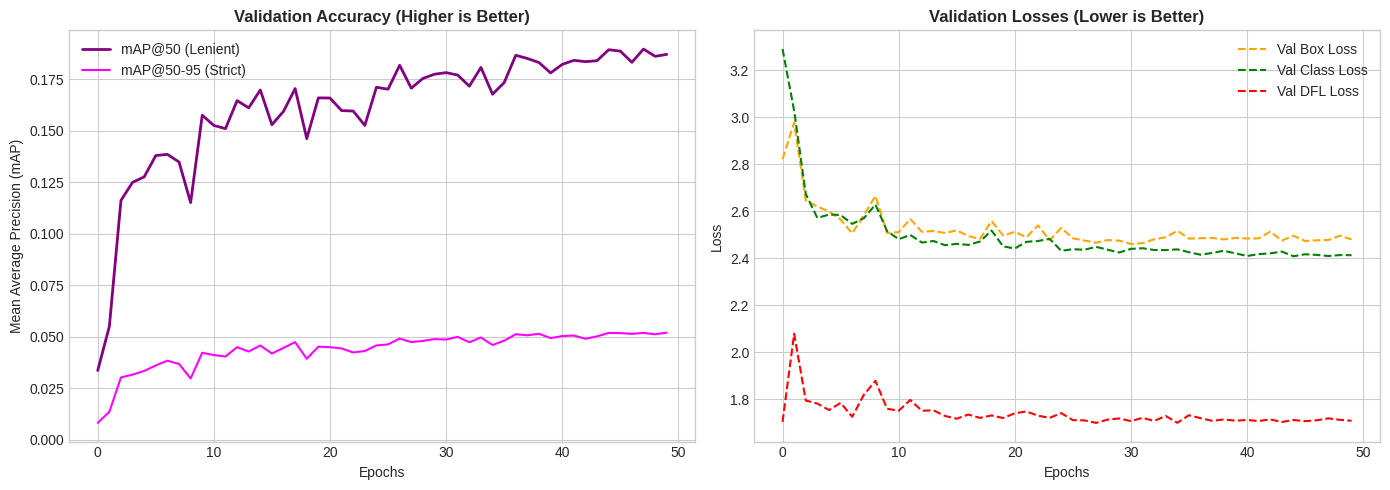

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set style for cleaner plots
plt.style.use('seaborn-v0_8-whitegrid')

# --- FIGURE 1: TRAINING LOSSES ---
plt.figure(figsize=(14, 5))

# Plot 1: SimCLR Loss (Phase 1)
plt.subplot(1, 2, 1)
if 'loss_history' in globals() and len(loss_history) > 0:
    plt.plot(loss_history, label='Contrastive Loss', color='blue', linewidth=2)
    plt.title("Phase 1: SimCLR Pre-training Loss", fontsize=12, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Contrastive)")
    plt.legend()
else:
    plt.text(0.5, 0.5, 'SimCLR History Not Found\n(Did Cell 6 run?)', 
             ha='center', va='center', fontsize=12)
    plt.title("Phase 1: SimCLR Pre-training Loss")

# Plot 2: YOLO Training Loss (Phase 2)
results_path = "/kaggle/working/Dental_Project/MultiClass_Run/results.csv"

plt.subplot(1, 2, 2)
if os.path.exists(results_path):
    # Read YOLO results CSV
    df = pd.read_csv(results_path)
    # Strip whitespace from column names (Ultralytics formatting issue)
    df.columns = [c.strip() for c in df.columns]
    
    # Plot the 3 main YOLO losses
    plt.plot(df['train/box_loss'], label='Box Loss (Location)', color='orange')
    plt.plot(df['train/cls_loss'], label='Class Loss (Type)', color='green')
    plt.plot(df['train/dfl_loss'], label='DFL Loss (Refinement)', color='red', linestyle=':')
    
    plt.title("Phase 2: Fine-Tuning Training Losses", fontsize=12, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
else:
    plt.text(0.5, 0.5, 'YOLO Results Not Found\n(Did Cell 7 run?)', 
             ha='center', va='center', fontsize=12)
    plt.title("Phase 2: Fine-Tuning Training Losses")

plt.tight_layout()
plt.show()

# --- FIGURE 2: VALIDATION METRICS ---
if os.path.exists(results_path):
    plt.figure(figsize=(14, 5))
    
    # Plot 3: Validation Accuracy (mAP)
    plt.subplot(1, 2, 1)
    plt.plot(df['metrics/mAP50(B)'], label='mAP@50 (Lenient)', color='purple', linewidth=2)
    plt.plot(df['metrics/mAP50-95(B)'], label='mAP@50-95 (Strict)', color='magenta')
    plt.title("Validation Accuracy (Higher is Better)", fontsize=12, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Average Precision (mAP)")
    plt.legend()
    
    # Plot 4: Validation Losses (Did we generalize?)
    plt.subplot(1, 2, 2)
    plt.plot(df['val/box_loss'], label='Val Box Loss', color='orange', linestyle='--')
    plt.plot(df['val/cls_loss'], label='Val Class Loss', color='green', linestyle='--')
    plt.plot(df['val/dfl_loss'], label='Val DFL Loss', color='red', linestyle='--')
    plt.title("Validation Losses (Lower is Better)", fontsize=12, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()